In [4]:
import pandas as pd
import os
from datetime import datetime, timedelta

# ==========================================
# 설정 (Settings)
# ==========================================
symbol = "BTCUSDT"
date_str = "2025-03-01"
top_n = 30
window = 60 # 검증할 윈도우 크기 (60분)

# 파일 경로
x_path = f"data/x/{date_str}_x_top{top_n}.h5"
raw_dir = "data/1m_raw_data"

# ==========================================
# 1. 데이터 로드 및 병합
# ==========================================
print(f"[INFO] {symbol} 데이터 추출 중...")

# (1) X 데이터 (Python이 계산한 Feature) 로드
if not os.path.exists(x_path):
 raise FileNotFoundError(f"X 파일 없음: {x_path}")

df_x = pd.read_hdf(x_path, key="x")
df_x = df_x[df_x["symbol"] == symbol].copy()

# Feature 컬럼만 선택 (중립화된 _neut 제외, 원본 Feature 값만 확인)
feat_cols = [c for c in df_x.columns if c.startswith(f"x_{window}m_") and not c.endswith("_neut")]
# 비교를 위해 필요한 시간, 심볼 정보
df_x_subset = df_x[["start_time_ms", "start_time_utc"] + feat_cols].copy()

# (2) Raw 데이터 (OHLCV 원본) 로드
# 윈도우 계산을 위해 전날 데이터도 필요
target_date = datetime.strptime(date_str, "%Y-%m-%d").date()
prev_date_str = (target_date - timedelta(days=1)).strftime("%Y-%m-%d")
raw_paths = [os.path.join(raw_dir, f"{d}.h5") for d in [prev_date_str, date_str]]

raw_list = []
for p in raw_paths:
 if os.path.exists(p):
    raw_list.append(pd.read_hdf(p))

if not raw_list:
 raise ValueError("원본 데이터 파일이 없습니다.")

df_raw = pd.concat(raw_list, ignore_index=True)
df_raw = df_raw[df_raw["symbol"] == symbol].copy()
df_raw = df_raw.sort_values("start_time_ms")

# (3) 두 데이터 병합 (Time 기준)
# Raw 데이터에 Feature 데이터를 붙임
merged = pd.merge(df_raw, df_x_subset, on=["start_time_ms", "start_time_utc"], how="left")

# 엑셀에서 보기 편하게 타겟 날짜 데이터만 남기되, 
# 엑셀 수식 검증을 위해 앞쪽 데이터(전날 23시~)도 일부 포함하여 저장
cutoff_time = df_x_subset["start_time_ms"].min() - (window * 60 * 1000 * 2) # 넉넉하게 윈도우 2배 전부터
merged_save = merged[merged["start_time_ms"] >= cutoff_time].copy()

# ==========================================
# 2. 엑셀로 내보내기
# ==========================================
output_file = f"{symbol}_verification_window{window}.xlsx"
merged_save.to_excel(output_file, index=False)

print(f"[DONE] 파일 생성 완료: {output_file}")

 # 3월 1일의 BTCUSDT 의 60min window에 대해 

 # feature가 올바르게 계산되었는 지 확인하기 위해 excel 수식을 이용해 검증하였음

[INFO] BTCUSDT 데이터 추출 중...
[DONE] 파일 생성 완료: BTCUSDT_verification_window60.xlsx


### Feature Checker for CloseDiffRatio, RatioSkewZ, OI_Z 

In [ ]:
import pandas as pd
import numpy as np
import os
import json

HDF5_PATH = 'data/x/2025-03-04_x_top30.h5'
target_timestamp = 1741132620000
df_x = pd.read_hdf(HDF5_PATH, key='x')


raw_files = ['data/1m_raw_data/2025-03-03.h5', 'data/1m_raw_data/2025-03-04.h5']
raw_dfs = []
for rf in raw_files:
    if os.path.exists(rf):
        try:
            raw_dfs.append(pd.read_hdf(rf))
        except:
            import h5py
            with h5py.File(rf, 'r') as f:
                keys = list(f.keys())
            raw_dfs.append(pd.read_hdf(rf, key=keys[0]))

In [2]:
btc = df_x[df_x['symbol']=='BTCUSDT']
btc[btc['start_time_ms']==1741132620000]

window = 15

In [3]:
raw = raw_dfs[1]
raw[raw['symbol']=='BTCUSDT']
btc_raw = raw[raw['symbol']=='BTCUSDT'].sort_values('start_time_ms').reset_index(drop=True)
# get index of target timestamp
idx = btc_raw.index[btc_raw['start_time_ms']==1741132620000]

In [4]:
btc_raw.iloc[idx[0]-(window-1):idx[0]+1]

,symbol,start_time_ms,start_time_utc,open,high,low,close,volume_base,quote_volume,num_trades,...,taker_buy_quote,pm_open,pm_high,pm_low,pm_close,mt_oi,mt_top_ls_ratio_cnt,mt_top_ls_ratio,mt_ls_ratio_cnt,mt_ls_vol_ratio
1423,BTCUSDT,1741131780000,2025-03-04 23:43:00,87301.0,87307.5,87266.9,87307.3,45.199,3.945187e+06,1092,...,9.195444e+05,-0.000397,-0.000164,-0.000563,-0.000340,5.916980e+09,1.990885,1.984824,1.788079,0.661138
1424,BTCUSDT,1741131840000,2025-03-04 23:44:00,87307.3,87380.0,87285.8,87373.5,71.212,6.217652e+06,1542,...,3.192032e+06,-0.000342,-0.000195,-0.000349,-0.000215,5.916980e+09,1.990885,1.984824,1.788079,0.661138
1425,BTCUSDT,1741131900000,2025-03-04 23:45:00,87373.4,87373.5,87300.6,87348.5,66.271,5.787315e+06,1497,...,2.116897e+06,-0.000400,-0.000066,-0.000463,-0.000338,5.915656e+09,1.988307,1.984456,1.783261,0.563536
1426,BTCUSDT,1741131960000,2025-03-04 23:46:00,87348.5,87348.5,87288.5,87290.6,46.623,4.070814e+06,1141,...,2.162037e+06,-0.000389,-0.000230,-0.000709,-0.000313,5.915656e+09,1.988307,1.984456,1.783261,0.563536
1427,BTCUSDT,1741132020000,2025-03-04 23:47:00,87290.6,87310.0,87260.0,87274.5,51.471,4.493036e+06,1328,...,2.551441e+06,-0.000630,-0.000209,-0.000630,-0.000498,5.915656e+09,1.988307,1.984456,1.783261,0.563536
1428,BTCUSDT,1741132080000,2025-03-04 23:48:00,87274.5,87307.4,87269.6,87271.7,37.209,3.247564e+06,1053,...,1.711242e+06,-0.000421,-0.000163,-0.000505,-0.000391,5.915656e+09,1.988307,1.984456,1.783261,0.563536
1429,BTCUSDT,1741132140000,2025-03-04 23:49:00,87271.8,87350.0,87271.7,87332.4,31.357,2.738213e+06,1285,...,1.364968e+06,-0.000441,-0.000225,-0.000441,-0.000348,5.915656e+09,1.988307,1.984456,1.783261,0.563536
1430,BTCUSDT,1741132200000,2025-03-04 23:50:00,87332.4,87360.0,87300.2,87359.9,62.134,5.426405e+06,1574,...,1.917072e+06,-0.000459,-0.000148,-0.000886,-0.000148,5.914453e+09,1.981589,1.982832,1.775578,0.949864
1431,BTCUSDT,1741132260000,2025-03-04 23:51:00,87360.0,87360.0,87280.0,87280.1,29.198,2.549465e+06,1316,...,1.312992e+06,-0.000333,-0.000272,-0.000650,-0.000436,5.914453e+09,1.981589,1.982832,1.775578,0.949864
1432,BTCUSDT,1741132320000,2025-03-04 23:52:00,87280.0,87299.9,87270.5,87292.9,45.099,3.936322e+06,1125,...,2.411770e+06,-0.000460,-0.000292,-0.000484,-0.000461,5.914453e+09,1.981589,1.982832,1.775578,0.949864


In [5]:
# --- Clear Manual Verification for BTCUSDT (15m Window) ---
window = 15

# Retrieve variables from previous cells
target_idx = idx[0]
target_window = window
target_ts = 1741132620000

# 1. Define the Window Slice
# Window is [t - window + 1, t]
start_pos = target_idx - target_window + 1
end_pos = target_idx

window_slice = btc_raw.iloc[start_pos : end_pos + 1]

print(f"Verifying {target_window}m_Close_Diff_Rate for BTCUSDT at {target_ts}")
print(f"Window Indices: {start_pos} to {end_pos} (Size: {len(window_slice)})")
print(f"Time Range: {window_slice['start_time_ms'].min()} -> {window_slice['start_time_ms'].max()}")

# 2. Get Values
c_first = window_slice['close'].iloc[0]
c_last = window_slice['close'].iloc[-1]

print(f"\n[Raw Data]")
print(f"  First Close (t-{target_window-1}): {c_first}")
print(f"  Last Close  (t):    {c_last}")

# 3. Calculate
manual_calc = (c_last / c_first) - 1.0
print(f"\n[Calculation]")
print(f"  ({c_last} / {c_first}) - 1.0 = {manual_calc:.10f}")

# 4. Compare with Model
# Check for column name (sometimes prefixed with x_)
col_name = f"{target_window}m_Close_Diff_Rate"
if col_name not in btc.columns:
     col_name = f"x_{target_window}m_Close_Diff_Rate"

if col_name in btc.columns:
    model_val = btc[btc['start_time_ms'] == target_ts][col_name].values[0]
    
    print(f"\n[Comparison]")
    print(f"  Manual: {manual_calc:.10f}")
    print(f"  Model:  {model_val:.10f}")
    print(f"  Diff:   {abs(manual_calc - model_val):.10e}")
else:
    print(f"\nColumn {col_name} not found in model data.")

Verifying 15m_Close_Diff_Rate for BTCUSDT at 1741132620000
Window Indices: 1423 to 1437 (Size: 15)
Time Range: 1741131780000 -> 1741132620000

[Raw Data]
  First Close (t-14): 87307.3
  Last Close  (t):    87252.5

[Calculation]
  (87252.5 / 87307.3) - 1.0 = -0.0006276680

[Comparison]
  Manual: -0.0006276680
  Model:  -0.0006276680
  Diff:   0.0000000000e+00


In [6]:
# --- Verify 15m_RatioSkew_Z ---
window = 15
target_ts = 1741132620000

# Ensure we have the target index
if len(btc_raw.index[btc_raw['start_time_ms'] == target_ts]) == 0:
    print(f"Target timestamp {target_ts} not found in btc_raw")
else:
    target_idx = btc_raw.index[btc_raw['start_time_ms'] == target_ts][0]

    # We need ratio_skew values for the last 'window' steps to calculate Z-score at target_idx
    # ratio_skew at index i uses data from [i - window + 1 : i]
    # So we need to iterate i from (target_idx - window + 1) to target_idx

    ratio_skew_values = []
    indices_for_z = range(target_idx - window + 1, target_idx + 1)

    print(f"Calculating RatioSkew for {len(indices_for_z)} steps to compute Z-score...")

    for i in indices_for_z:
        # Slice for RatioSkew calculation at index i
        # Data needed: [i - window + 1 : i]
        start_p = i - window + 1
        end_p = i
        
        # Ensure we have data (handle negative indices if necessary, though unlikely here)
        if start_p < 0:
            # If we need data from previous file, this simple check fails. 
            # But assuming we are late in the file:
            ratio_skew_values.append(0.0) 
            continue
            
        slice_df = btc_raw.iloc[start_p : end_p + 1]
        
        # Calculate RatioSkew
        # ratio_skew = mean(mt_top_ls_ratio) - mean(mt_ls_ratio_cnt)
        if 'mt_top_ls_ratio' in slice_df.columns and 'mt_ls_ratio_cnt' in slice_df.columns:
            top_ls_mean = slice_df['mt_top_ls_ratio'].mean()
            ls_mean = slice_df['mt_ls_ratio_cnt'].mean()
            r_skew = top_ls_mean - ls_mean
            ratio_skew_values.append(r_skew)
        else:
            ratio_skew_values.append(0.0)

    # Now calculate Z-score of the last value in ratio_skew_values
    # using the window of ratio_skew_values
    rs_series = pd.Series(ratio_skew_values)

    # Manual Z-score
    # The Z-score at the last step uses the mean/std of the last 'window' steps of ratio_skew
    # Since we collected exactly 'window' steps, we use the whole series
    rs_mean = rs_series.mean()
    rs_std = rs_series.std(ddof=0) + 1e-9
    rs_last = rs_series.iloc[-1]

    manual_z = (rs_last - rs_mean) / rs_std

    print(f"\n[RatioSkew Data (Last 5)]")
    print(rs_series.tail().values)
    print(f"\n[Z-Score Calculation]")
    print(f"  Mean: {rs_mean:.10f}")
    print(f"  Std:  {rs_std:.10f}")
    print(f"  Last: {rs_last:.10f}")
    print(f"  Z:    ({rs_last} - {rs_mean}) / {rs_std} = {manual_z:.10f}")

    # Compare
    col_name = f"{window}m_RatioSkew_Z"
    # Check if column exists (sometimes prefixed)
    if col_name not in btc.columns:
         col_name = f"x_{window}m_RatioSkew_Z" # Just in case, though x_generator output usually doesn't have x_ prefix in columns inside the file, but let's be safe

    if col_name in btc.columns:
        model_val = btc[btc['start_time_ms'] == target_ts][col_name].values[0]
        print(f"\n[Comparison]")
        print(f"  Manual: {manual_z:.10f}")
        print(f"  Model:  {model_val:.10f}")
        print(f"  Diff:   {abs(manual_z - model_val):.10e}")
    else:
        print(f"Column {col_name} not found in model data.")

Calculating RatioSkew for 15 steps to compute Z-score...

[RatioSkew Data (Last 5)]
[0.20058231 0.20173131 0.2024918  0.20325228 0.20401277]

[Z-Score Calculation]
  Mean: 0.1973955108
  Std:  0.0042355087
  Last: 0.2040127673
  Z:    (0.20401276733333296 - 0.19739551075555553) / 0.004235508691580015 = 1.5623286504

[Comparison]
  Manual: 1.5623286504
  Model:  1.5623286504
  Diff:   2.5083490840e-11


In [7]:
# --- Verify 15m_OI_Z ---
window = 15
target_ts = 1741132620000

# Ensure we have the target index
if len(btc_raw.index[btc_raw['start_time_ms'] == target_ts]) == 0:
    print(f"Target timestamp {target_ts} not found in btc_raw")
else:
    target_idx = btc_raw.index[btc_raw['start_time_ms'] == target_ts][0]
    
    # Window slice for OI
    # Data needed: [target_idx - window + 1 : target_idx]
    start_pos = target_idx - window + 1
    end_pos = target_idx
    
    window_slice = btc_raw.iloc[start_pos : end_pos + 1]
    
    if 'mt_oi' in window_slice.columns:
        oi_series = window_slice['mt_oi']
        
        # Calculate components
        oi_last = oi_series.iloc[-1]
        oi_mean = oi_series.mean()
        oi_std = oi_series.std(ddof=0) + 1e-9
        
        # Formula from x_generator.py:
        # oi_z = (oi_last / oi_mean - 1.0) / (oi_std / oi_mean)
        
        
        manual_oi_z = (oi_last / oi_mean - 1.0) / (oi_std / oi_mean)
        
        print(f"Verifying {window}m_OI_Z for BTCUSDT at {target_ts}")
        print(f"\n[OI Data]")
        print(f"  Last: {oi_last}")
        print(f"  Mean: {oi_mean}")
        print(f"  Std:  {oi_std}")
        
        print(f"\n[Calculation]")
        print(f"  ({oi_last} / {oi_mean} - 1.0) / ({oi_std} / {oi_mean}) = {manual_oi_z:.10f}")
        
        # Compare
        col_name = f"{window}m_OI_Z"
        if col_name not in btc.columns:
             col_name = f"x_{window}m_OI_Z"

        if col_name in btc.columns:
            model_val = btc[btc['start_time_ms'] == target_ts][col_name].values[0]
            print(f"\n[Comparison]")
            print(f"  Manual: {manual_oi_z:.10f}")
            print(f"  Model:  {model_val:.10f}")
            print(f"  Diff:   {abs(manual_oi_z - model_val):.10e}")
        else:
            print(f"Column {col_name} not found in model data.")
            
    else:
        print("Column 'mt_oi' not found in raw data.")

Verifying 15m_OI_Z for BTCUSDT at 1741132620000

[OI Data]
  Last: 5911336510.674255
  Mean: 5914567802.818707
  Std:  1806426.2212936282

[Calculation]
  (5911336510.674255 / 5914567802.818707 - 1.0) / (1806426.2212936282 / 5914567802.818707) = -1.7887761517

[Comparison]
  Manual: -1.7887761517
  Model:  -1.7887761603
  Diff:   8.6272118338e-09


In [12]:
import pandas as pd
import numpy as np

def inspect_features(df: pd.DataFrame, keywords=None, name="Subset"):
    """
    DataFrame에서 특정 키워드가 포함된 피처들의 건강 상태(NaN, Inf, Stats)를 점검합니다.
    
    Args:
        df: 검증할 DataFrame
        keywords: 컬럼 이름에 포함될 문자열 리스트 (예: ['O2C', 'O2H']). None이면 전체 검사.
        name: 출력할 때 표시할 그룹 이름
    """
    # 1. 검증할 컬럼 선별
    if keywords:
        target_cols = [c for c in df.columns if any(k in c for k in keywords)]
    else:
        target_cols = df.columns.tolist()

    print(f"\n{'='*10} [ 검증 그룹: {name} (총 {len(target_cols)}개 컬럼) ] {'='*10}")
    
    if not target_cols:
        print("❌ 해당 키워드를 가진 컬럼이 없습니다.")
        return

    subset = df[target_cols]
    
    # 2. 결측치(NaN) 체크
    nan_sum = subset.isna().sum()
    total_nans = nan_sum.sum()
    if total_nans > 0:
        print(f"⚠️ [NaN 경고] 총 {total_nans}개의 결측치가 발견되었습니다!")
        print(nan_sum[nan_sum > 0].sort_values(ascending=False).head(5)) # 상위 5개만 출력
    else:
        print("✅ 결측치(NaN): 없음")

    # 3. 무한대(Inf) 체크
    numeric_cols = subset.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        inf_sum = np.isinf(subset[numeric_cols]).sum()
        total_infs = inf_sum.sum()
        if total_infs > 0:
            print(f"⚠️ [Inf 경고] 총 {total_infs}개의 무한대(Inf) 값이 발견되었습니다!")
            print(inf_sum[inf_sum > 0])
        else:
            print("✅ 무한대(Inf): 없음")
    
    # 4. 기초 통계량 (Min, Max, Mean, Std) 확인
    stats = subset.describe().T[['mean', 'min', 'max', 'std']]
    
    # 이상하게 튀는 값(Outlier)이 있는지 대략적으로 확인
    print(f"\n📊 [통계 요약 - 상위 5개]")
    print(stats.head(5)) 
    

In [18]:
DATE = "2024-03-07"   
TOP_N = 30            
DATA_DIR = "data"    

file_name = f"{DATE}_xy_top{TOP_N}.h5"
file_path = os.path.join(DATA_DIR, "xy", file_name)

df = pd.read_hdf(file_path, mode='r')

# 2. 그룹별로 검사 실행
# (1) Price 관련 피처 (O2C, H2C 등)
inspect_features(df, keywords=['H2L_Vol'], name="Price Features")

# (2) Volume 관련 피처
inspect_features(df, keywords=['AvgTrade', 'C2VWAP', 'NetTaker'], name="Volume/Flow Features")

# (3) OI 및 기타 지표
inspect_features(df, keywords=['OI_Chg', 'WhaleGap', 'Premium'], name="Sentiment Features")

 # 3월 1일의 BTCUSDT 의 60min window에 대해 엑셀을 사용해 위의 7개 피쳐에 대한 검증 마침



========== [ 검증 그룹: Price Features (총 20개 컬럼) ] ==========
✅ 결측치(NaN): 없음
✅ 무한대(Inf): 없음

📊 [통계 요약 - 상위 5개]
                     mean        min          max         std
x_1m_H2L_Vol    31.010410   0.029909   697.061463   24.579377
x_5m_H2L_Vol    72.052832   5.933244  1121.263745   54.727121
x_15m_H2L_Vol  126.641739  12.627712  1759.192502   94.768144
x_30m_H2L_Vol  179.997394  27.713409  1864.135224  132.326585
x_60m_H2L_Vol  253.112682  47.736295  1983.835415  183.691460

========== [ 검증 그룹: Volume/Flow Features (총 60개 컬럼) ] ==========
✅ 결측치(NaN): 없음
✅ 무한대(Inf): 없음

📊 [통계 요약 - 상위 5개]
                     mean        min           max         std
x_1m_AvgTrade  553.176856  37.925557  14470.298000  797.131743
x_1m_NetTaker   -0.000739  -0.891817      0.968887    0.259432
x_1m_C2VWAP     -0.053096 -91.743119    152.237968    8.622747
x_5m_AvgTrade  565.226149  54.261061   8716.465276  797.107468
x_5m_NetTaker   -0.008981  -0.608563      0.721509    0.149266

========== [ 검증 그룹: Senti

In [46]:
import numpy as np

# 1) X로 시작하는 컬럼만 선택

DATE = "2024-02-10"   
TOP_N = 30            
DATA_DIR = "data"    

file_name = f"{DATE}_xy_top{TOP_N}.h5"
file_path = os.path.join(DATA_DIR, "xy", file_name)
x_cols = [c for c in df.columns if c.startswith("x")]
y_cols = [c for c in df.columns if c.startswith("y")]
# 2) 각 컬럼에 대해 NaN, Inf 체크
for col in x_cols:
    col_data = df[col]
    has_nan = col_data.isna().any()
    has_pos_inf = np.isposinf(col_data).any()
    has_neg_inf = np.isneginf(col_data).any()

    if has_nan or has_pos_inf or has_neg_inf:
        print(f"[WARN] Column '{col}' has NaN/Inf -> "
              f"NaN: {has_nan}, +inf: {has_pos_inf}, -inf: {has_neg_inf}")
    #else:
        #print(f"[OK] Column '{col}' is clean.")


[MISS] data/xy/2024-03-31_xy_top30.h5 not found, skip.
[MISS] data/xy/2024-04-01_xy_top30.h5 not found, skip.
[MISS] data/xy/2024-04-02_xy_top30.h5 not found, skip.
[MISS] data/xy/2024-06-21_xy_top30.h5 not found, skip.
[MISS] data/xy/2024-06-22_xy_top30.h5 not found, skip.
[MISS] data/xy/2025-07-21_xy_top30.h5 not found, skip.
[MISS] data/xy/2025-07-22_xy_top30.h5 not found, skip.
[MISS] data/xy/2025-07-23_xy_top30.h5 not found, skip.
[MISS] data/xy/2025-10-31_xy_top30.h5 not found, skip.


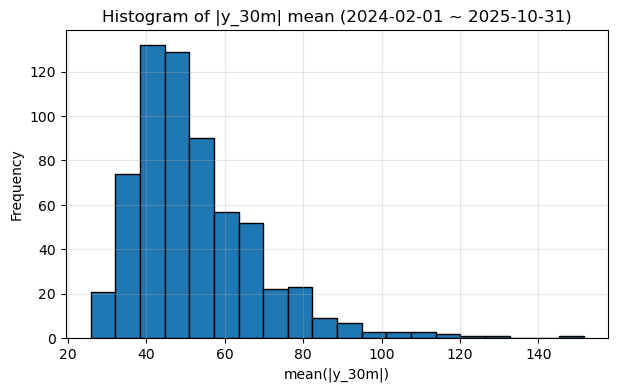

In [54]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_y30m_abs_mean_hist(start_date: str, end_date: str, top_n: int = 30, data_dir: str = "data"):
    """
    start_date ~ end_date 사이 날짜별로 y_30m의 절댓값 평균을 계산하고, 
    그 분포를 히스토그램으로 표시.
    """
    date_range = pd.date_range(start=start_date, end=end_date)
    abs_means = []

    for date in date_range:
        date_str = date.strftime("%Y-%m-%d")
        file_name = f"{date_str}_xy_top{top_n}.h5"
        file_path = os.path.join(data_dir, "xy", file_name)

        if not os.path.exists(file_path):
            print(f"[MISS] {file_path} not found, skip.")
            continue

        try:
            df = pd.read_hdf(file_path)
        except Exception as e:
            print(f"[ERR] {file_path}: {e}")
            continue

        if "y_30m" not in df.columns:
            print(f"[WARN] 'y_30m' column not in {file_path}")
            continue

        mean_val = df["y_30m"].abs().mean()
        abs_means.append(mean_val)
        #print(f"[OK] {date_str}: mean(abs(y_30m)) = {mean_val:.6f}")

    if not abs_means:
        print("No valid data found in given date range.")
        return

    # 시각화
    plt.figure(figsize=(7, 4))
    plt.hist(abs_means, bins=20, edgecolor="black")
    plt.title(f"Histogram of |y_30m| mean ({start_date} ~ {end_date})")
    plt.xlabel("mean(|y_30m|)")
    plt.ylabel("Frequency")
    plt.grid(alpha=0.3)
    plt.show()


# 예시 실행
plot_y30m_abs_mean_hist("2024-02-01", "2025-10-31", top_n=30, data_dir="data")


In [34]:
import os
import json
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

DATA_DIR = "data"
TOP_N = 30
OUTPUT_JSON = "global_ban_dates.json"


def check_xy_file(date_str, result_dict):
    """특정 날짜의 xy 파일에서 x로 시작하는 컬럼의 NaN/Inf 컬럼을 체크."""
    file_name = f"{date_str}_xy_top{TOP_N}.h5"
    file_path = os.path.join(DATA_DIR, "xy", file_name)

    # 파일 없음
    if not os.path.exists(file_path):
        print(f"[FILE NOT FOUND] {file_name}")
        result_dict["missing_dates"].append(date_str)
        return

    df = pd.read_hdf(file_path, mode='r')
    x_cols = [c for c in df.columns if c.startswith("x")]

    bad_cols = []
    for col in x_cols:
        col_data = df[col]
        if (
            col_data.isna().any()
            or np.isposinf(col_data).any()
            or np.isneginf(col_data).any()
        ):
            bad_cols.append(col)

    # 문제 있는 컬럼 기록
    if bad_cols:
        print(f"[WARN] {date_str} 문제 컬럼:", bad_cols)
        result_dict["nan_dates"][date_str] = bad_cols
    else:
        print(f"[OK] {date_str} 정상")


def check_range(start_date, end_date):
    """전체 날짜 구간 검사 + JSON 저장."""
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end   = datetime.strptime(end_date, "%Y-%m-%d")

    # 결과 딕셔너리
    result_dict = {
        "missing_dates": [],
        "nan_dates": {}
    }

    cur = start
    while cur <= end:
        date_str = cur.strftime("%Y-%m-%d")
        check_xy_file(date_str, result_dict)
        cur += timedelta(days=1)

    # 결과 JSON 저장
    with open(OUTPUT_JSON, "w") as f:
        json.dump(result_dict, f, indent=4)

    print(f"\n[RESULT SAVED] → {OUTPUT_JSON}")
    return result_dict


# ================================
# 사용 예시
# ================================
# result = check_range("2024-03-01", "2024-03-10")
# print(result)


In [36]:
result = check_range("2024-02-01", "2025-10-31")
result

[OK] 2024-02-01 정상
[OK] 2024-02-02 정상
[OK] 2024-02-03 정상
[OK] 2024-02-04 정상
[OK] 2024-02-05 정상
[OK] 2024-02-06 정상
[OK] 2024-02-07 정상
[OK] 2024-02-08 정상
[OK] 2024-02-09 정상
[OK] 2024-02-10 정상
[OK] 2024-02-11 정상
[OK] 2024-02-12 정상
[OK] 2024-02-13 정상
[OK] 2024-02-14 정상
[OK] 2024-02-15 정상
[WARN] 2024-02-16 문제 컬럼: ['x_15m_OI_P_Corr', 'x_30m_OI_P_Corr', 'x_60m_OI_P_Corr', 'x_120m_OI_P_Corr', 'x_240m_OI_P_Corr', 'x_480m_OI_P_Corr', 'x_15m_OI_P_Corr_neut', 'x_30m_OI_P_Corr_neut', 'x_60m_OI_P_Corr_neut', 'x_120m_OI_P_Corr_neut', 'x_240m_OI_P_Corr_neut', 'x_480m_OI_P_Corr_neut']
[OK] 2024-02-17 정상
[WARN] 2024-02-18 문제 컬럼: ['x_1m_AvgTrade', 'x_1m_NetTaker', 'x_1m_C2VWAP', 'x_1m_AvgTrade_neut', 'x_1m_NetTaker_neut', 'x_1m_C2VWAP_neut']
[OK] 2024-02-19 정상
[OK] 2024-02-20 정상
[OK] 2024-02-21 정상
[OK] 2024-02-22 정상
[OK] 2024-02-23 정상
[OK] 2024-02-24 정상
[OK] 2024-02-25 정상
[OK] 2024-02-26 정상
[OK] 2024-02-27 정상
[WARN] 2024-02-28 문제 컬럼: ['x_5m_OI_Chg', 'x_5m_OI_Z', 'x_5m_OI_Price_Ratio', 'x_5m_OI_XSkew', 'x

{'missing_dates': ['2024-03-31',
  '2024-04-01',
  '2024-04-02',
  '2024-06-21',
  '2024-06-22',
  '2025-07-21',
  '2025-07-22',
  '2025-07-23',
  '2025-10-31'],
 'nan_dates': {'2024-02-16': ['x_15m_OI_P_Corr',
   'x_30m_OI_P_Corr',
   'x_60m_OI_P_Corr',
   'x_120m_OI_P_Corr',
   'x_240m_OI_P_Corr',
   'x_480m_OI_P_Corr',
   'x_15m_OI_P_Corr_neut',
   'x_30m_OI_P_Corr_neut',
   'x_60m_OI_P_Corr_neut',
   'x_120m_OI_P_Corr_neut',
   'x_240m_OI_P_Corr_neut',
   'x_480m_OI_P_Corr_neut'],
  '2024-02-18': ['x_1m_AvgTrade',
   'x_1m_NetTaker',
   'x_1m_C2VWAP',
   'x_1m_AvgTrade_neut',
   'x_1m_NetTaker_neut',
   'x_1m_C2VWAP_neut'],
  '2024-02-28': ['x_5m_OI_Chg',
   'x_5m_OI_Z',
   'x_5m_OI_Price_Ratio',
   'x_5m_OI_XSkew',
   'x_15m_OI_Chg',
   'x_15m_OI_Price_Ratio',
   'x_30m_OI_Chg',
   'x_30m_OI_Price_Ratio',
   'x_60m_OI_Chg',
   'x_60m_OI_Price_Ratio',
   'x_120m_OI_Chg',
   'x_120m_OI_Price_Ratio',
   'x_240m_OI_Chg',
   'x_240m_OI_Price_Ratio',
   'x_480m_OI_Chg',
   'x_480m_OI_Pr